# Introduction
This notebook will handle a denoising autoencoder on the MNIST-dataset.

# Imports

In [82]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

import tensorflow as tf
from tensorflow import keras
from tensorflow import image
from tensorflow import core
from tensorflow.keras import layers
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ",keras.__version__)

tf.random.set_seed(42)
np.random.seed(42)

kaggle = 0 # Kaggle path active = 1

# change your local path here
if kaggle == 1 :
    MNIST_PATH= '../input/digit-recognizer'
else:
    MNIST_PATH= '../autoencoding-mnist/data/input/digit-recognizer'



import os
for dirname, _, filenames in os.walk(MNIST_PATH): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

Tensorflow Version:  2.3.0
Keras Version:  2.4.0
../autoencoding-mnist/data/input/digit-recognizer\keras_reg_160_10_002.sav
../autoencoding-mnist/data/input/digit-recognizer\keras_reg_jl_160_10_002.sav
../autoencoding-mnist/data/input/digit-recognizer\sample_submission.csv
../autoencoding-mnist/data/input/digit-recognizer\test.csv
../autoencoding-mnist/data/input/digit-recognizer\train.csv


## Get Data And Prepare It

In [83]:
# Data path and file
CSV_FILE_TRAIN='train.csv'
CSV_FILE_TEST='test.csv'

def load_mnist_data(minist_path, csv_file):
    csv_path = os.path.join(minist_path, csv_file)
    return pd.read_csv(csv_path)

def load_mnist_data_manuel(minist_path, csv_file):
    csv_path = os.path.join(minist_path, csv_file)
    csv_file = open(csv_path, 'r')
    csv_data = csv_file.readlines()
    csv_file.close()
    return csv_data

def split_train_val(data, val_ratio):
    return 
    

train = load_mnist_data(MNIST_PATH,CSV_FILE_TRAIN)
test = load_mnist_data(MNIST_PATH,CSV_FILE_TEST)

### Train Val Split

In [84]:
X_train, X_valid, y_train, y_val =  train_test_split(train.loc[:, train.columns != 'label'], train['label'], test_size=0.33, random_state=42)

### Preparing for Neural Network Structure

#### Datapipeline

In [85]:
# Pipeline for data transformation
pipeline = Pipeline([
    ('std_scalar', StandardScaler())
    #('normalizer', Normalizer())
])

In [86]:
X_train = pipeline.fit_transform(X_train)
X_valid = pipeline.fit_transform(X_valid)

#### Reshaping Data in Tensor Batch Structure

In [87]:
X_train_prep = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_valid_prep = X_valid.reshape(X_valid.shape[0], 28, 28, 1)

y_train =  y_train.values.reshape(y_train.shape[0], 1)
y_val = y_val.values.reshape(y_val.shape[0], 1)

# Plotting 

In [88]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid_prep[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))

    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid_prep[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
    


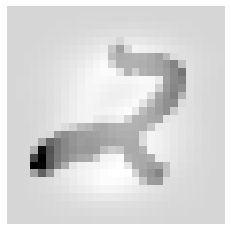

In [89]:
plot_image(X_valid_prep[6])

# Model Creation - Deep Denoising Autoencoder

In [90]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="relu"),
    keras.layers.Reshape([28, 28])
])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))


In [91]:
dropout_encoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_13 (Dense)             (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [92]:
dropout_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_15 (Dense)             (None, 784)               79184     
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


## Training 

In [93]:
history = dropout_ae.fit(X_train_prep, X_train_prep, epochs= 10, validation_data=(X_valid_prep, X_valid_prep))

Epoch 1/10
880/880 [==============================] - 2s 2ms/step - loss: 0.8912 - val_loss: 0.8371
Epoch 2/10
880/880 [==============================] - 2s 2ms/step - loss: 0.8194 - val_loss: 0.8169
Epoch 3/10
880/880 [==============================] - 2s 2ms/step - loss: 0.8169 - val_loss: 0.8169
Epoch 4/10
880/880 [==============================] - 2s 2ms/step - loss: 0.8169 - val_loss: 0.8169
Epoch 5/10
880/880 [==============================] - 2s 2ms/step - loss: 0.8048 - val_loss: 0.7976
Epoch 6/10
880/880 [==============================] - 2s 2ms/step - loss: 0.7976 - val_loss: 0.7976
Epoch 7/10
880/880 [==============================] - 2s 2ms/step - loss: 0.7975 - val_loss: 0.7976
Epoch 8/10
880/880 [==============================] - 2s 2ms/step - loss: 0.7951 - val_loss: 0.7794
Epoch 9/10
880/880 [==============================] - 2s 2ms/step - loss: 0.7782 - val_loss: 0.7781
Epoch 10/10
880/880 [==============================] - 2s 2ms/step - loss: 0.7781 - val_loss: 0.7781

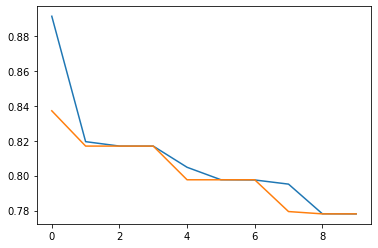

In [94]:
# Getting in touch with the model statistics 
# shows the available keys in models history:  print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


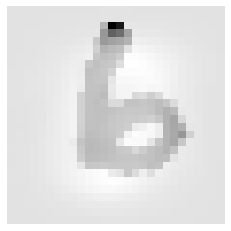

In [95]:
# Test image from a known set
plot_image(X_train_prep[1])


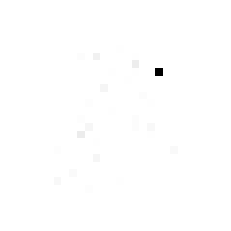

In [96]:
#plot_image()
#dropout_ae.predict(X_valid_prep[:1]).shape
plot_image(dropout_ae.predict(X_valid_prep[:10])[8])

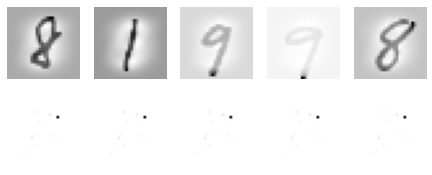

In [102]:
show_reconstructions(dropout_ae)

In [98]:
X_train_prep.shape
X_valid_prep.shape

(13860, 28, 28, 1)